In [1]:
import sys; 
import ast
from glob import glob
import cv2
from skimage import io
import os
from datetime import datetime
import time
import random
from tqdm import tqdm
from contextlib import contextmanager
import math
from pathlib import Path

import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
from sklearn.model_selection import GroupKFold, StratifiedKFold, KFold
import torch
import torchvision
from torchvision import transforms
from torch import nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.optim import Adam, SGD, AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler
import timm
import warnings
import joblib
from scipy.ndimage.interpolation import zoom
import nibabel as nib
import pydicom as dicom

C:\Users\KIM\AppData\Local\Temp\ipykernel_8496\4182502781.py:37: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import zoom


### preprocess 및 datafram(path) 만들기

In [2]:
datadir = 'preprocess_test' # root dir

In [28]:
# Store segmentation paths in a dataframe
seg_paths = glob(f"{datadir}/segmentations/*") # nii 파일 다 불러오기
seg_df = pd.DataFrame({'path': seg_paths}) # nii 파일 path 저장
# seg_df['StudyInstanceUID'] = seg_df['path'].apply(lambda x:x.split('/')[-1][:-4]) # 환자 번호?
seg_df['StudyInstanceUID'] = seg_df['path'].apply(lambda x: os.path.basename(x)[:-4])
seg_df = seg_df[['StudyInstanceUID','path']] # 환자 번호, path 주장
print('seg_df shape:', seg_df.shape)
seg_df.head(3)

seg_df shape: (1, 2)


,StudyInstanceUID,path
0,137,preprocess_test/segmentations\137.nii


In [37]:
def standardize_pixel_array(dcm: dicom.dataset.FileDataset) -> np.ndarray:
    """
    From : https://www.kaggle.com/competitions/rsna-2023-abdominal-trauma-detection/discussion/427217
    """
    pixel_array = dcm.pixel_array
    if dcm.PixelRepresentation == 1:
        bit_shift = dcm.BitsAllocated - dcm.BitsStored
        dtype = pixel_array.dtype

        pixel_array = (pixel_array << bit_shift).astype(dtype) >> bit_shift

    intercept = float(dcm.RescaleIntercept)
    slope = float(dcm.RescaleSlope)
    center = int(dcm.WindowCenter)
    width = int(dcm.WindowWidth)
    low = center - width / 2
    high = center + width / 2

    pixel_array = (pixel_array * slope) + intercept
    pixel_array = np.clip(pixel_array, low, high)

    return pixel_array

In [38]:
def process(dcm):
    img = standardize_pixel_array(dcm) # 표준화된 pixel_array return
    img = (img - img.min()) / (img.max() - img.min() + 1e-6)

    if dcm.PhotometricInterpretation == "MONOCHROME1": # 흑백 반전인지
        img = 1 - img

    return img # pixel_array

In [39]:
def load_dicom(path, img_size):
    """
    This supports loading both regular and compressed JPEG images. 
    See the first sell with `pip install` commands for the necessary dependencies
    """
    dcm = dicom.dcmread(path)
    img = process(dcm)
    # img.PhotometricInterpretation = 'YBR_FULL' # ?
    # data = img.pixel_array
    # data = data - np.min(data)
    # if np.max(data) != 0:
    #     data = data / np.max(data)
    # img = cv2.resize(img, (img_size[0], img_size[1]))
    img = (img * 255).astype(np.uint8)
    return cv2.cvtColor(img, cv2.COLOR_GRAY2RGB), dcm # 이미지 array, dcm reader로 읽은 정보

In [40]:
# z 축 정렬
# def get_images(series_id, image_dir):
#     file_paths = list(image_dir.glob(f"*/{series_id}/*.dcm"))

#     imgs = {}
#     for file_path in file_paths:
#         dcm = dicom.dcmread(file_path)
#         pos_z = dcm.ImagePositionPatient[-1]  # to retrieve the order of frames
#         img = process(dcm)
#         imgs[pos_z] = img # z축을 key, pixel array를 value

#     imgs = {k: v for k, v in sorted(imgs.items())} # z축을 기준으로 정렬
#     imgs = np.array(list(imgs.values())) 
#     return imgs

In [41]:
study_uid_list = seg_df["StudyInstanceUID"].tolist() # nii 파일 리스트

In [42]:
dataframe_list = []
os.makedirs(f"{datadir}/seg_25d_image", exist_ok=True)
os.makedirs(f"{datadir}/seg_25d_mask", exist_ok=True)
img_size = (128, 128)

for file_name in tqdm(study_uid_list): # nii 파일 가져오기
    ex_path = f"{datadir}/segmentations/{file_name}.nii"
    mask = nib.load(ex_path)
    mask = mask.get_fdata()  # convert to numpy array
    mask = mask[:, ::-1, ::-1].transpose(1, 0, 2)
    mask = np.clip(mask,0,8).astype(np.uint8)
    mask = np.ascontiguousarray(mask)

    train_image_path = glob(f"{datadir}/train_images/{file_name}/*")
    # seg_df['StudyInstanceUID'] = seg_df['path'].apply(lambda x: os.path.basename(x)[:-4])
    # train_image_path = sorted(train_image_path, key=lambda x:int(train_image_path.split("/")[-1].replace(".dcm","")))
    train_image_path = sorted(train_image_path, key=lambda x:int(os.path.basename(x)[:-4]))
    image_list = []
    for path in train_image_path:
        im, meta = load_dicom(path, img_size) # pixel array(3ch) 정보만 사용
        image_list.append(im[:,:,0]) # x,y축만 사용하고 단일 채널만 사용(1ch)
    image = np.stack(image_list, axis=2) # 모든 이미지 쌓기 >> 밑에서 3장씩 쌓음.
    
    assert image.shape == mask.shape, f"Image and mask {file_name} should be the same size, but are {image.shape} and {mask.shape}"
    slice_num = image.shape[2]

    for i in range(1, slice_num-1):
        image_25d = image[:,:, i-1:i+2]
        mask_25d = mask[:,:, i-1:i+2]
        assert image_25d.shape == mask_25d.shape == (512, 512, 3), f"Image and mask {file_name} should be (512, 512, 3), but are {image_25d.shape} and {mask_25d.shape}"
        image_save_path = f"{datadir}/seg_25d_image/{file_name}_{i}.npy"
        mask_save_path =  f"{datadir}/seg_25d_mask/{file_name}_{i}.npy"
        np.save(image_save_path, image_25d)
        np.save(mask_save_path, mask_25d)
        dataframe_list.append([f"{file_name}_{i}", file_name, i, image_save_path, mask_save_path])

100%|██████████| 1/1 [03:10<00:00, 190.99s/it]


In [43]:
seg_25d_df = pd.DataFrame(dataframe_list, columns=["id", "StudyInstanceUID", "slice_num", "image_path", "mask_path"]) # id = {file_name}_{i} = "StudyInstanceUID"_"slice_num"

In [75]:
seg_25d_df.to_csv(f"{datadir}/seg_25d.csv", index=False)

### visualization

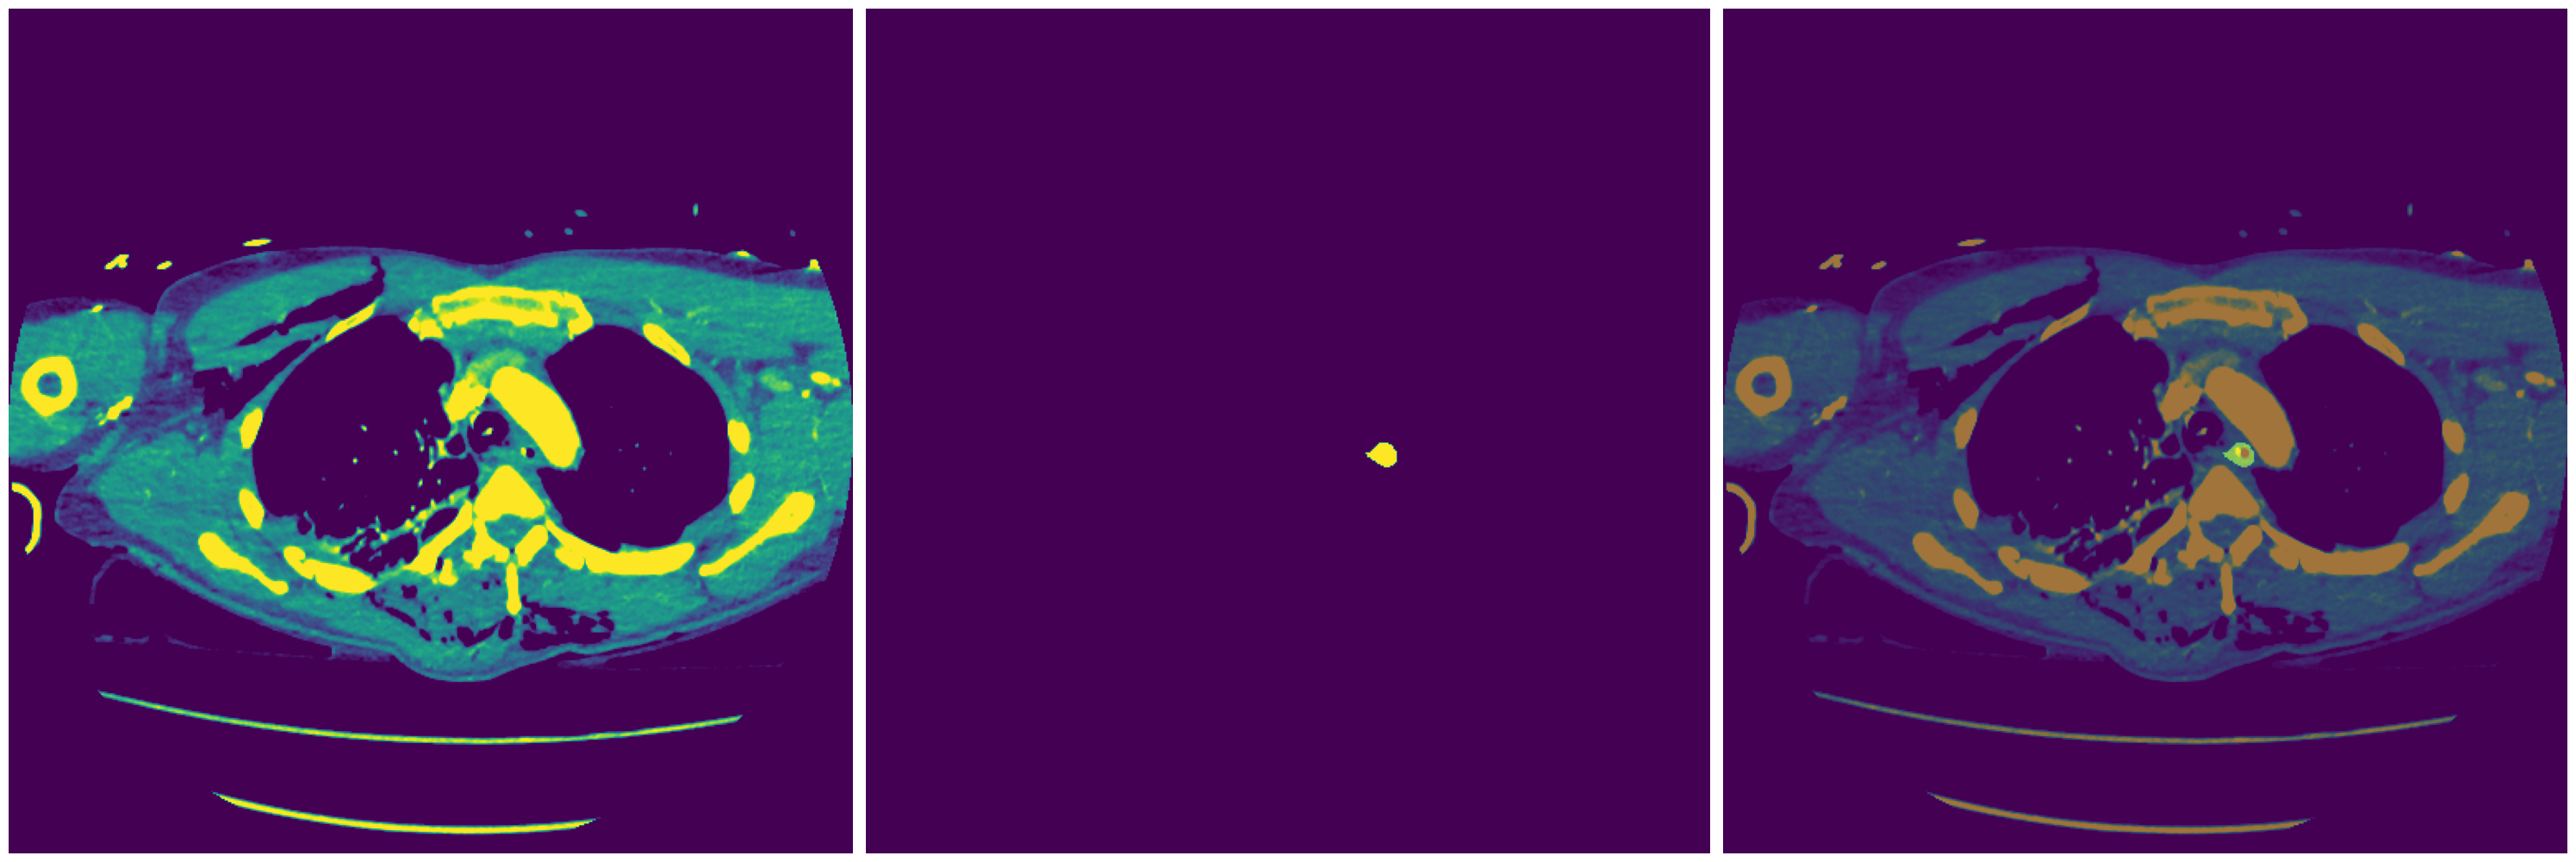

In [47]:
example_name = "137_1"
image_example = np.load(f"{datadir}/seg_25d_image/{example_name}.npy").transpose(2,0,1)
mask_example = np.load(f"{datadir}/seg_25d_mask/{example_name}.npy").transpose(2,0,1)
plt.figure(figsize=(30, 20))
plt.subplot(1, 3, 1); plt.imshow(image_example[1]); plt.axis('OFF');
plt.subplot(1, 3, 2); plt.imshow(mask_example[1]); plt.axis('OFF');
plt.subplot(1, 3, 3); plt.imshow(image_example[1]); plt.imshow(mask_example[1],alpha=0.5); plt.axis('OFF');
# plt.colorbar()
plt.tight_layout()
plt.show()

### fold 만들기

In [ ]:
seg_25d_df["fold"] = -1

gkf = GroupKFold(n_splits=5)
for idx, (train_index, test_index) in enumerate(gkf.split(X=seg_25d_df, groups=seg_25d_df['StudyInstanceUID'].values)):
    seg_25d_df.loc[test_index, 'fold'] = idx

In [ ]:
for i in range(5):
    study_num = len(np.unique(seg_25d_df[seg_25d_df["fold"] == i]["StudyInstanceUID"]))
    print(f"fold{i} num: {study_num}")

In [ ]:
# seg_25d_df.to_csv(f"{datadir}/seg_25d.csv", index=False)

In [3]:
df = pd.read_csv(f"{datadir}/train.csv")
df.head()

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury
0,10004,1,0,0,1,0,1,0,1,0,0,0,0,1,1
1,10005,1,0,1,0,1,0,0,1,0,0,1,0,0,0
2,10007,1,0,1,0,1,0,0,1,0,0,1,0,0,0
3,10026,1,0,1,0,1,0,0,1,0,0,1,0,0,0
4,10051,1,0,1,0,1,0,0,1,0,0,0,1,0,1


In [69]:
df[df['patient_id'] == 137].count()

patient_id               0
bowel_healthy            0
bowel_injury             0
extravasation_healthy    0
extravasation_injury     0
kidney_healthy           0
kidney_low               0
kidney_high              0
liver_healthy            0
liver_low                0
liver_high               0
spleen_healthy           0
spleen_low               0
spleen_high              0
any_injury               0
dtype: int64

In [4]:
cols = [
    "bowel_injury",
    "extravasation_injury",
    "kidney_low",
    "kidney_high",
    "liver_low",
    "liver_high",
    "spleen_low",
    "spleen_high",
]

In [1]:
from pathlib import Path
import pandas as pd
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

k = 4
cols = [
    "bowel_injury",
    "extravasation_injury",
    "kidney_low",
    "kidney_high",
    "liver_low",
    "liver_high",
    "spleen_low",
    "spleen_high",
]

# data_dir = "/mnt/f/AI_competitions/kaggle/RSNA/"

# df = pd.read_csv(data_dir + "train.csv")

mskf = MultilabelStratifiedKFold(n_splits=k, shuffle=False)
splits = mskf.split(df, y=df[cols])

df["fold"] = -1

TypeError: __init__() takes 2 positional arguments but 4 were given

In [14]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
# from iterative-stratification import MultilabelStratifiedKFold

k=4
mskf = MultilabelStratifiedKFold(n_splits=k, shuffle=True, random_state=42)
# mskf = MultilabelStratifiedKFold(n_splits=k, shuffle=False)
splits = mskf.split(df, y=df[cols])
df["fold"] = -1

for i, (_, val_idx) in enumerate(splits):
    df.loc[val_idx, "fold"] = i

df

TypeError: __init__() takes 2 positional arguments but 4 were given

In [3]:
pip uninstall iterative-stratification

In [ ]:
df.to_csv(datadir/"split.csv", index=False)

for col in cols:
    print(df.groupby(["fold", col]).size())

In [61]:
pip install iterative-stratification==0.1.6

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

root = Path(__file__).absolute().parents[1]
data_dir = root / "data"
datadir

k = 4

cols = [
    "bowel_injury",
    "extravasation_injury",
    "kidney_low",
    "kidney_high",
    "liver_low",
    "liver_high",
    "spleen_low",
    "spleen_high",
]


def run():
    df = pd.read_csv(datadir/"train.csv")

    mskf = MultilabelStratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    splits = mskf.split(df, y=df[cols])

    df["fold"] = -1
    for i, (_, val_idx) in enumerate(splits):
        df.loc[val_idx, "fold"] = i

    df.to_csv(data_dir / "split.csv", index=False)

    for col in cols:
        print(df.groupby(["fold", col]).size())


if __name__ == "__main__":
    run()